In [4]:
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision.transforms import *
import torchvision.models as models
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from skimage.transform import resize, rescale
import skimage.io as skio

import xml.etree.ElementTree as ET 
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import os
import glob

In [6]:
class LargeFaceDataset(Dataset):
    def __init__(self, img_transform=None, keypoint_transform=None, total_imgs=32):
        tree = ET.parse('ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train.xml')
        root = tree.getroot()
        root_dir = 'ibug_300W_large_face_landmark_dataset'
        self.root_dir = 'ibug_300W_large_face_landmark_dataset'
        
        bboxes = [] # face bounding box used to crop the image
        landmarks = [] # the facial keypoints/landmarks for the whole training dataset
        img_filenames = [] # the image names for the whole dataset

        for filename in root[2]:
            img_filenames.append(os.path.join(root_dir, filename.attrib['file']))
            box = filename[0].attrib
            # x, y for the top left corner of the box, w, h for box width and height
            bboxes.append([box['left'], box['top'], box['width'], box['height']]) 

            landmark = []
            for num in range(68):
                x_coordinate = int(filename[0][num].attrib['x'])
                y_coordinate = int(filename[0][num].attrib['y'])
                landmark.append([x_coordinate, y_coordinate])
            landmarks.append(landmark)
        
        self.landmarks = np.array(landmarks).astype('float32')     
        self.bboxes = np.array(bboxes).astype('float32')
        self.img_filenames = img_filenames 

        self.img_transform = img_transform
        self.keypoint_transform = keypoint_transform
    
    def __len__(self):
        return len(self.img_filenames)
    
    def __getitem__(self, idx):
        img_path = self.img_filenames[idx]
        points = self.landmarks[idx]
        bbox = self.bboxes[idx]

        img = skio.imread(img_path, as_gray=True)
        img = np.float64(img)
        height = img.shape[0]
        width = img.shape[1]

        top = int(abs(bbox[1]))
        new_h = max(int(bbox[3]) + 40, int(bbox[2]) + 40, 224)
        left = int(abs(bbox[0]))
        img = img[top: top + new_h, left: left + new_h]

        # offset for crop
        points = points - [left, top]

        # renormalize points to new width and height
        points[:, 0] = points[:, 0] / new_h
        points[:, 1] = points[:, 1] / new_h

        sample = {'x': img, 'y': points}
        
        if self.keypoint_transform:
            sample = self.keypoint_transform(sample)
        
        if self.img_transform:
            img = self.img_transform(img)
   
        return {'x': img, 'y': sample['y']}


In [7]:
batch_size = 32
validation_split = 0.2
height = 224
width = 224
channels = 1

img_transforms = Compose([
            ToTensor(),
            Normalize(mean=[0.485],
                      std=[0.229]),
            Resize((height, width)),
            ColorJitter(),
        ])

keypoint_transforms = None

dataset = LargeFaceDataset(img_transform=img_transforms, keypoint_transform=keypoint_transforms)

dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

In [8]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.resnet18 = models.resnet18(pretrained=True)
        
        self.resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.resnet18.fc = nn.Linear(512, 68*2)

    def forward(self, x):

        x = self.resnet18(x)
        return x


In [148]:
model = ResNet().double()

lr = 1e-4
optimizer = optim.Adam(model.parameters(), lr=lr)

checkpoint = torch.load('checkpoint_14', map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
criterion = nn.MSELoss()

model.eval()

ResNet(
  (resnet18): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

Loss:  0.02994722469473999


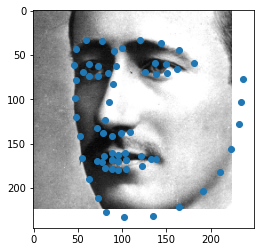

Loss:  0.030600545138418523


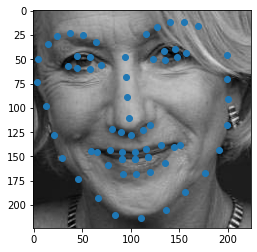

Loss:  0.004786385440958534


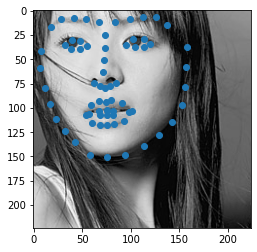

Loss:  0.005786300241595782


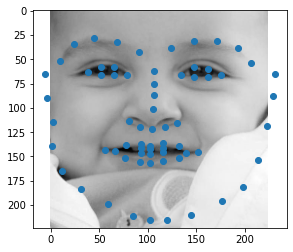

Loss:  0.014456111500279903


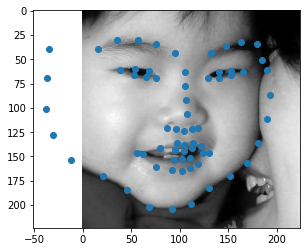

Loss:  0.005850190214787922


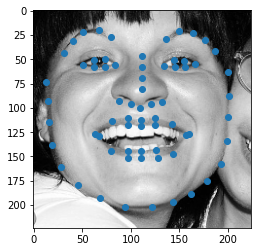

Loss:  0.0333415317046623


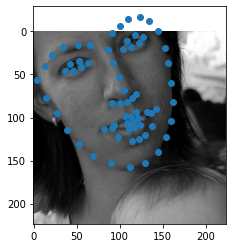

Loss:  0.008418963008167411


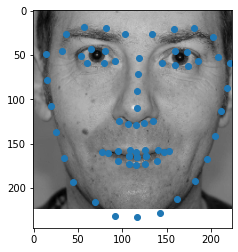

Loss:  0.0064451391958692565


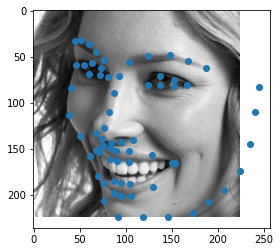

Loss:  0.016966444415341276


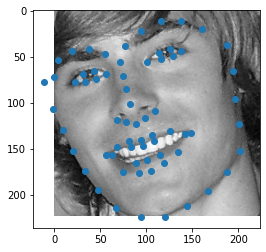

Loss:  0.00576197794834577


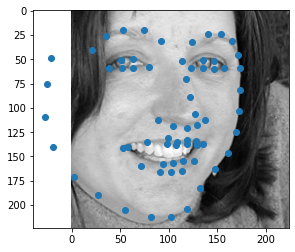

Loss:  0.006857796681328314


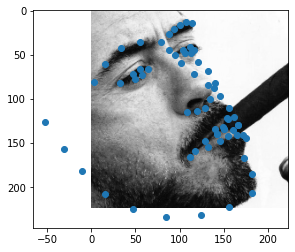

Loss:  0.02118596936248962


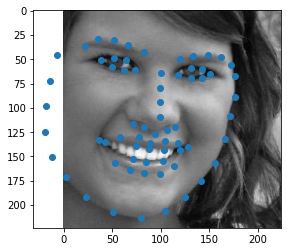

Loss:  0.0065527349922744815


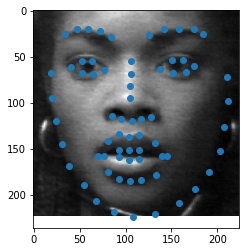

Loss:  0.0076328282130938415


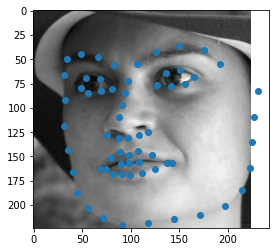

Loss:  0.030827909140039397


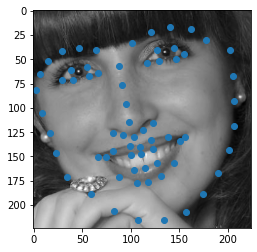

Loss:  0.006178621151532539


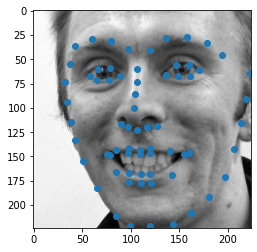

Loss:  0.008214504017132885


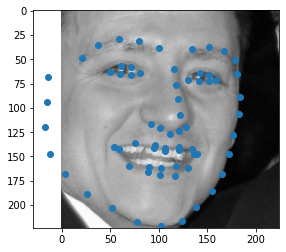

Loss:  0.00924664963372391


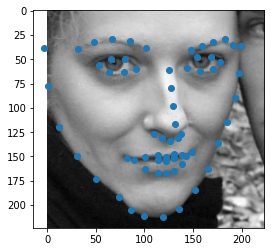

Loss:  0.005458743623863882


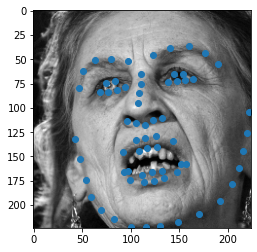

Loss:  0.009357024721120957


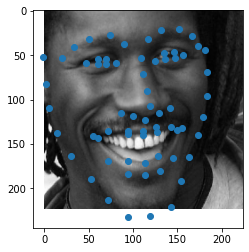

Loss:  0.005680678590104283


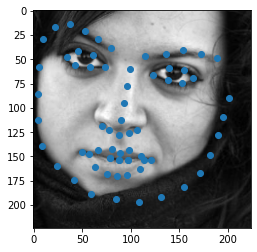

Loss:  0.005368948526432273


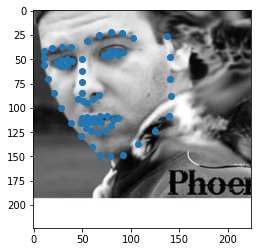

Loss:  0.014663372462980025


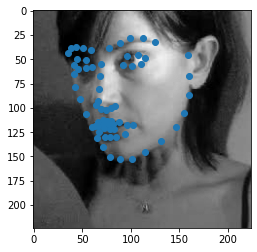

Loss:  0.025737720165913823


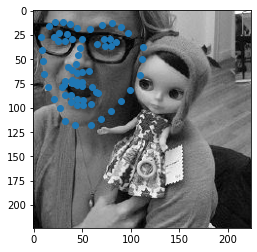

Loss:  0.013236588897446576


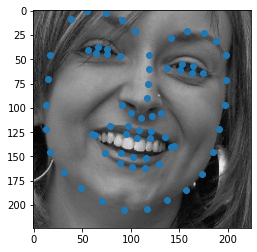

Loss:  0.0073592222120707615


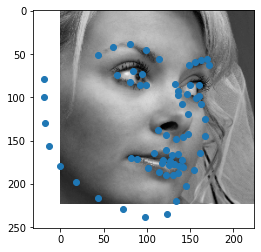

Loss:  0.007292600224732702


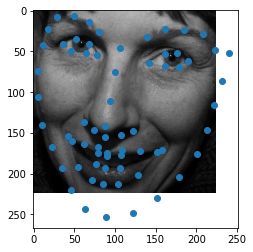

Loss:  0.006304567959010818


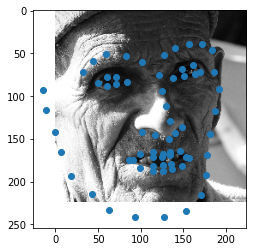

Loss:  0.00674326164135068


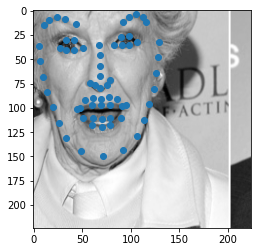

Loss:  0.007433752773855322


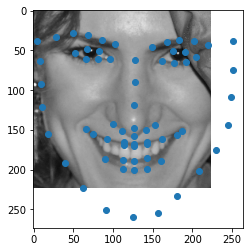

Loss:  0.005531660668000049


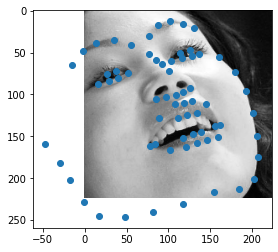

Loss:  0.0072250429307471635


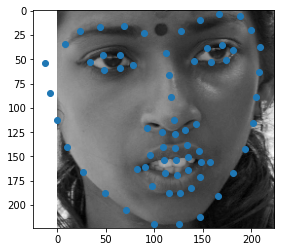

Loss:  0.0056398594406992355


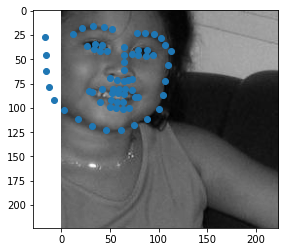

Loss:  0.005992378095148353


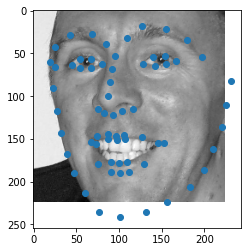

Loss:  0.009361489770772191


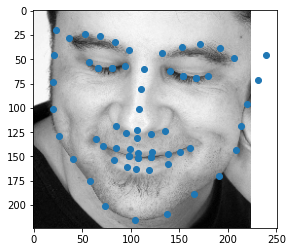

Loss:  0.00471359836689934


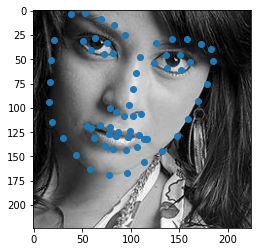

Loss:  0.006398364363352457


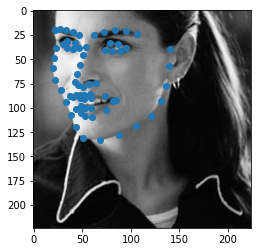

Loss:  0.007515501221390863


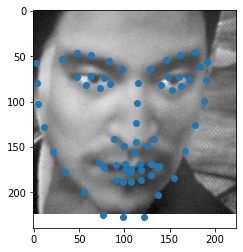

Loss:  0.005293025057459059


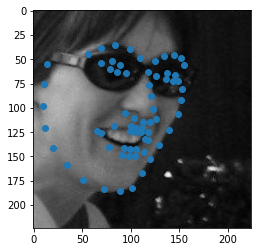

Loss:  0.027910540143833946


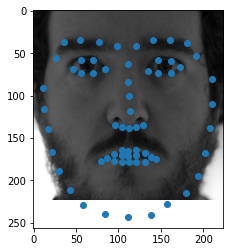

Loss:  0.006036041176756105


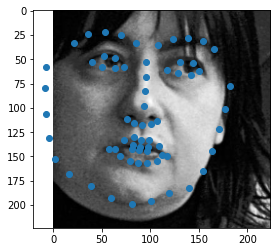

In [111]:
with torch.no_grad():
    for batch_i, sample_batch in enumerate(validation_loader):
        images = sample_batch['x']
        points = sample_batch['y']
        target = points

        output = model(images)
        output = output.reshape(target.shape)
        loss = criterion(output, target)
        print("Loss: ", loss.item())

        plt.imshow(images[0].squeeze(), cmap='gray')
        plt.scatter(points[0, :, 0] * images[0].shape[2], points[0, :, 1] * images[0].shape[1])
        plt.show()

# Test Data

In [107]:
class TestFaceDataset(Dataset):
    def __init__(self):
        tree = ET.parse('labels_ibug_300W_test_parsed.xml')
        root = tree.getroot()
        root_dir = 'ibug_300W_large_face_landmark_dataset'
        self.root_dir = 'ibug_300W_large_face_landmark_dataset'
        
        bboxes = [] # face bounding box used to crop the image
        img_filenames = [] # the image names for the whole dataset

        for filename in root[2]:
            img_filenames.append(os.path.join(root_dir, filename.attrib['file']))
            box = filename[0].attrib
            # x, y for the top left corner of the box, w, h for box width and height
            bboxes.append([box['left'], box['top'], box['width'], box['height']]) 

        self.bboxes = np.array(bboxes).astype('float32')
        self.img_filenames = img_filenames
        
        self.transforms = Compose([            
            ToTensor(),
            Normalize(mean=[0.485],
                      std=[0.229]),
            Resize((224, 224)),])
    
    def __len__(self):
        return len(self.img_filenames)
    
    def __getitem__(self, idx):
        img_path = self.img_filenames[idx]
        bbox = self.bboxes[idx]

        img = skio.imread(img_path, as_gray=True)
        img = np.float64(img)
        height = img.shape[0]
        width = img.shape[1]

        top = int(abs(bbox[1]))
        new_h = max(int(bbox[3]) + 40, int(bbox[2]) + 40, 224)
        left = int(abs(bbox[0]))
        img = img[top: top + new_h, left: left + new_h]

        img = self.transforms(img)
        return img

    def bbox_points_to_orig_points(self, idx, points):
        img_path = self.img_filenames[idx]
        bbox = self.bboxes[idx]

        img = skio.imread(img_path, as_gray=True)
        img = np.float64(img)
        
        height = img.shape[0]
        width = img.shape[1]
        
        top = int(abs(bbox[1]))
        new_h = max(int(bbox[3]) + 40, int(bbox[2]) + 40, 224)
        left = int(abs(bbox[0]))
        
        # unnormalize points
        points[:, 0] = points[:, 0] * new_h
        points[:, 1] = points[:, 1] * new_h
        
        # undo crop to square
        points = points + [left, top]

        return img_path, img, points

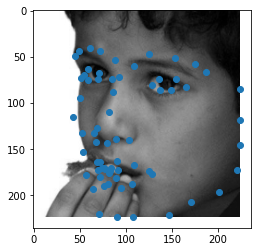

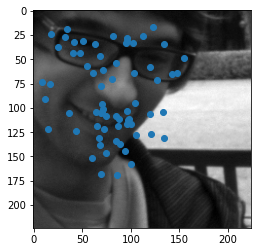

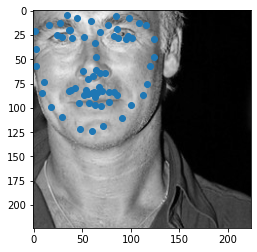

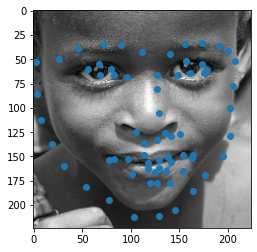

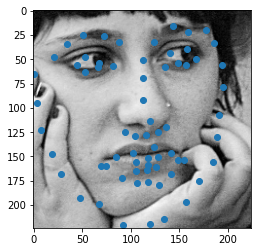

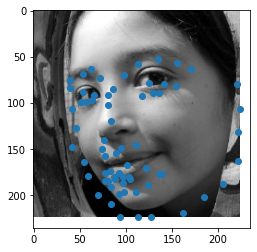

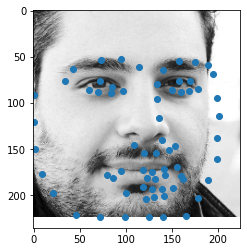

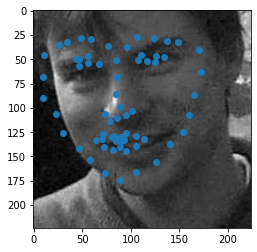

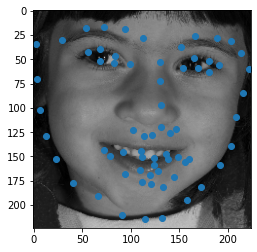

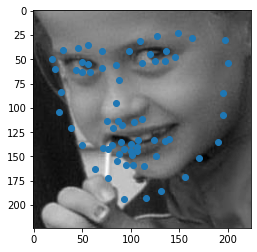

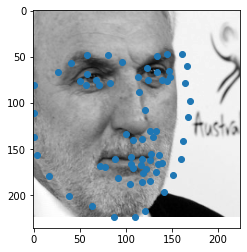

In [122]:
dataset = TestFaceDataset()
test_data_loader = DataLoader(dataset=dataset)
with torch.no_grad():
    for i, d in enumerate(test_data_loader):
        if i > 10:
            break
        output = model(d)
        points = output.reshape((-1, 2))
        points = np.clip(points, 0, 1)
        plt.imshow(d.squeeze(), cmap='gray')
        plt.scatter(points[:, 0] * d.shape[2], points[:, 1] * d.shape[3])
        plt.show()



In [143]:
dataset = TestFaceDataset()
test_data_loader = DataLoader(dataset=dataset)

ids = np.arange(len(dataset)*68*2)
pred_points = np.ndarray(137088)
print(len(dataset))
with torch.no_grad():
    curr_i = 0
    for img_i, d in enumerate(test_data_loader):
        output = model(d)
        
        points = output.reshape((-1, 2))
        points = np.clip(points, 0, 1)
        points = points.numpy()
        
        img_path, d, points = dataset.bbox_points_to_orig_points(img_i, points)
        points = points.flatten()
        
        pred_points[curr_i:curr_i + points.shape[0]] = points
        print(points.shape, curr_i, curr_i + points.shape[0])
        curr_i += points.shape[0]

1008
(136,) 0 136
(136,) 136 272
(136,) 272 408
(136,) 408 544
(136,) 544 680
(136,) 680 816
(136,) 816 952
(136,) 952 1088
(136,) 1088 1224
(136,) 1224 1360
(136,) 1360 1496
(136,) 1496 1632
(136,) 1632 1768
(136,) 1768 1904
(136,) 1904 2040
(136,) 2040 2176
(136,) 2176 2312
(136,) 2312 2448
(136,) 2448 2584
(136,) 2584 2720
(136,) 2720 2856
(136,) 2856 2992
(136,) 2992 3128
(136,) 3128 3264
(136,) 3264 3400
(136,) 3400 3536
(136,) 3536 3672
(136,) 3672 3808
(136,) 3808 3944
(136,) 3944 4080
(136,) 4080 4216
(136,) 4216 4352
(136,) 4352 4488
(136,) 4488 4624
(136,) 4624 4760
(136,) 4760 4896
(136,) 4896 5032
(136,) 5032 5168
(136,) 5168 5304
(136,) 5304 5440
(136,) 5440 5576
(136,) 5576 5712
(136,) 5712 5848
(136,) 5848 5984
(136,) 5984 6120
(136,) 6120 6256
(136,) 6256 6392
(136,) 6392 6528
(136,) 6528 6664
(136,) 6664 6800
(136,) 6800 6936
(136,) 6936 7072
(136,) 7072 7208
(136,) 7208 7344
(136,) 7344 7480
(136,) 7480 7616
(136,) 7616 7752
(136,) 7752 7888
(136,) 7888 8024
(136,) 80

(136,) 59976 60112
(136,) 60112 60248
(136,) 60248 60384
(136,) 60384 60520
(136,) 60520 60656
(136,) 60656 60792
(136,) 60792 60928
(136,) 60928 61064
(136,) 61064 61200
(136,) 61200 61336
(136,) 61336 61472
(136,) 61472 61608
(136,) 61608 61744
(136,) 61744 61880
(136,) 61880 62016
(136,) 62016 62152
(136,) 62152 62288
(136,) 62288 62424
(136,) 62424 62560
(136,) 62560 62696
(136,) 62696 62832
(136,) 62832 62968
(136,) 62968 63104
(136,) 63104 63240
(136,) 63240 63376
(136,) 63376 63512
(136,) 63512 63648
(136,) 63648 63784
(136,) 63784 63920
(136,) 63920 64056
(136,) 64056 64192
(136,) 64192 64328
(136,) 64328 64464
(136,) 64464 64600
(136,) 64600 64736
(136,) 64736 64872
(136,) 64872 65008
(136,) 65008 65144
(136,) 65144 65280
(136,) 65280 65416
(136,) 65416 65552
(136,) 65552 65688
(136,) 65688 65824
(136,) 65824 65960
(136,) 65960 66096
(136,) 66096 66232
(136,) 66232 66368
(136,) 66368 66504
(136,) 66504 66640
(136,) 66640 66776
(136,) 66776 66912
(136,) 66912 67048
(136,) 67048

(136,) 117096 117232
(136,) 117232 117368
(136,) 117368 117504
(136,) 117504 117640
(136,) 117640 117776
(136,) 117776 117912
(136,) 117912 118048
(136,) 118048 118184
(136,) 118184 118320
(136,) 118320 118456
(136,) 118456 118592
(136,) 118592 118728
(136,) 118728 118864
(136,) 118864 119000
(136,) 119000 119136
(136,) 119136 119272
(136,) 119272 119408
(136,) 119408 119544
(136,) 119544 119680
(136,) 119680 119816
(136,) 119816 119952
(136,) 119952 120088
(136,) 120088 120224
(136,) 120224 120360
(136,) 120360 120496
(136,) 120496 120632
(136,) 120632 120768
(136,) 120768 120904
(136,) 120904 121040
(136,) 121040 121176
(136,) 121176 121312
(136,) 121312 121448
(136,) 121448 121584
(136,) 121584 121720
(136,) 121720 121856
(136,) 121856 121992
(136,) 121992 122128
(136,) 122128 122264
(136,) 122264 122400
(136,) 122400 122536
(136,) 122536 122672
(136,) 122672 122808
(136,) 122808 122944
(136,) 122944 123080
(136,) 123080 123216
(136,) 123216 123352
(136,) 123352 123488
(136,) 123488

In [144]:
arr = np.vstack([ids, pred_points]).T
np.savetxt("kaggle.csv", arr, delimiter=",", header='Id,Predicted', fmt='%i, %1.4f')

# Personal Photo Test

test_personal/Screen Shot 2020-11-08 at 9.54.17 PM.png
finding keypoints


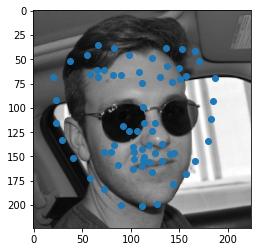

test_personal/Screen Shot 2020-11-08 at 10.03.37 PM.png
finding keypoints


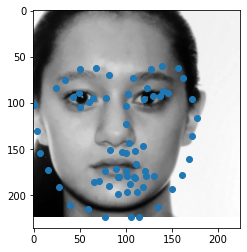

test_personal/passport_crop copy.png
finding keypoints


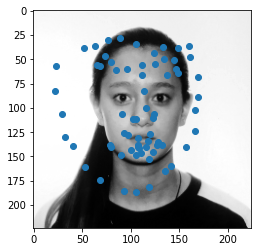

test_personal/Screen Shot 2020-11-08 at 9.58.59 PM.png
finding keypoints


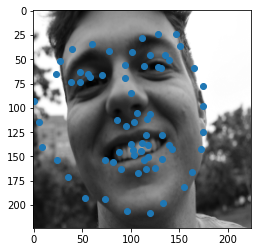

test_personal/Screen Shot 2020-11-08 at 9.59.18 PM.png
finding keypoints


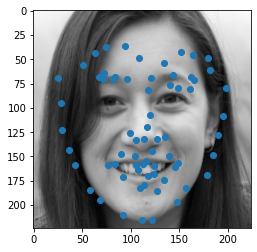

test_personal/Screen Shot 2020-11-08 at 10.04.29 PM.png
finding keypoints


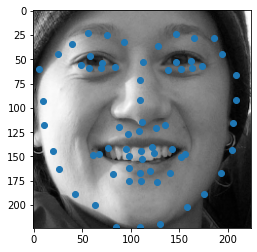

In [149]:
class PersonalData(Dataset):
    def __init__(self, img_dir):
        self.img_filenames = [os.path.join(img_dir, f) for f in os.listdir(img_dir)] # the image names for the whole dataset
        self.transforms = Compose([            
                ToTensor(),
                Normalize(mean=[0.485],
                          std=[0.229]),
                Resize((224, 224)),])
        
    def __len__(self):
        return len(self.img_filenames)
    
    def __getitem__(self, idx):
        img_path = self.img_filenames[idx]
        print(img_path)
        img = skio.imread(img_path, as_gray=True)
        img = np.float64(img)
        img = self.transforms(img)
        
        return img

personal_dataset = PersonalData('test_personal')
personal_data_loader = DataLoader(dataset=personal_dataset)

with torch.no_grad():
    for i, d in enumerate(personal_data_loader):
        print("finding keypoints")
        output = model(d)
        points = output.reshape((-1, 2))
        points = np.clip(points, 0, 1)
        plt.imshow(d.squeeze(), cmap='gray')
        plt.scatter(points[:, 0] * d.shape[2], points[:, 1] * d.shape[3])
        plt.show()

